In [1]:
import os
import numpy as np
import pandas as pd
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from scipy.cluster.hierarchy import dendrogram, linkage

np.random.seed(5)
directory = 'C:/Users/lelin/Desktop/ADM/MACHINE LEARNING/MovieSummaries/movie descriptions'
os.chdir(directory)
movies_df = pd.read_excel('movies.xlsx')
print("Number of movies loaded: %s " % (len(movies_df)))

Number of movies loaded: 100 


In [2]:
movies_df

Release Year                            Title              Genre  \
0           1931               The Maltese Falcon              drama   
1           1937  Snow White and the Seven Dwarfs  animated, musical   
2           1939               Gone with the Wind         epic drama   
3           1939                 The Wizard of Oz    musical fantasy   
4           1940              The Grapes of Wrath              drama   
..           ...                              ...                ...   
95          1975    The Rocky Horror Picture Show    musical, comedy   
96          1995                       Braveheart   drama, biography   
97          1964                     My Fair Lady            musical   
98          1999                  American Beauty              drama   
99          1983                         Scarface        crime drama   

                                            wiki_plot  \
0   In San Francisco, private investigator Sam Spa...   
1   Snow White is a lonely princess living with he...   
2   On the eve of the American Civil War in 1861, ...   
3   The film begins in Kansas, which is depicted i...   
4   The film opens with Tom Joad (Henry Fonda), re...   
..                                                ...   
95  A criminologist narrates the tale of the newly...   
96  In 1280, King Edward "Longshanks" invades and ...   
97  In Edwardian London, Professor Henry Higgins (...   
98  Lester Burnham is a middle-aged office worker ...   
99  In 1980, Cuban refugee and ex-con Antonio "Ton...   

                                            imdb_plot  
0   Private eye Sam Spade and his partner Miles Ar...  
1   A prologue in the form of text from an ornatel...  
2   The film opens in Tara, a cotton plantation ow...  
3   Dorothy Gale (Judy Garland) is an orphaned tee...  
4   After serving four years in prison for killing...  
..                                                ...  
95  In 1280, King Edward "Longshanks" invades and ...  
96  In 1280, King Edward "Longshanks" invades and ...  
97  Henry Higgins (Rex Harrison), an arrogant, ira...  
98  Lester Burnham (Kevin Spacey) is a 42-year-old...  
99  In May 1980, a Cuban man named Tony Montana (A...  

[100 rows x 5 columns]

In [3]:
# Combine wiki_plot and imdb_plot into a single column
movies_df["plot"] = movies_df["wiki_plot"].astype(str) + "\n" + \
                    movies_df["imdb_plot"].astype(str)
# Inspect the new DataFrame
movies_df.head()

Release Year                            Title              Genre  \
0          1931               The Maltese Falcon              drama   
1          1937  Snow White and the Seven Dwarfs  animated, musical   
2          1939               Gone with the Wind         epic drama   
3          1939                 The Wizard of Oz    musical fantasy   
4          1940              The Grapes of Wrath              drama   

                                           wiki_plot  \
0  In San Francisco, private investigator Sam Spa...   
1  Snow White is a lonely princess living with he...   
2  On the eve of the American Civil War in 1861, ...   
3  The film begins in Kansas, which is depicted i...   
4  The film opens with Tom Joad (Henry Fonda), re...   

                                           imdb_plot  \
0  Private eye Sam Spade and his partner Miles Ar...   
1  A prologue in the form of text from an ornatel...   
2  The film opens in Tara, a cotton plantation ow...   
3  Dorothy Gale (Judy Garland) is an orphaned tee...   
4  After serving four years in prison for killing...   

                                                plot  
0  In San Francisco, private investigator Sam Spa...  
1  Snow White is a lonely princess living with he...  
2  On the eve of the American Civil War in 1861, ...  
3  The film begins in Kansas, which is depicted i...  
4  The film opens with Tom Joad (Henry Fonda), re...

In [4]:
import re
import nltk

nltk.download('punkt')
nltk.download('stopwords')

custom_stopwords = set(stopwords.words('english'))
custom_stopwords.update(['and', 'that', 'with', 'the', 'to', 'x000D', 'him','his','her','hers','n\'t'])  # Add more custom stopwords

sent_tokenized = [sent for sent in nltk.sent_tokenize("""
                        Today (May 19, 2016) is his only daughter's wedding. 
                        Vito Corleone is the Godfather.
                        """)]
words_tokenized = [word for word in nltk.word_tokenize(sent_tokenized[0])]
filtered = [word for word in words_tokenized if re.search('[a-zA-Z]', word)]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lelin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lelin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
filtered

['Today', 'May', 'is', 'his', 'only', 'daughter', "'s", 'wedding']

In [6]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")
print("Without stemming: ", filtered)
stemmed_words = [stemmer.stem(t) for t in filtered]
print("After stemming:   ", stemmed_words)

Without stemming:  ['Today', 'May', 'is', 'his', 'only', 'daughter', "'s", 'wedding']
After stemming:    ['today', 'may', 'is', 'his', 'onli', 'daughter', "'s", 'wed']


In [7]:

def tokenize_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = [token for token in tokens if re.search('[a-zA-Z]', token)]
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems
    
words_stemmed = tokenize_and_stem("Today (May 19, 2016) is his only daughter's wedding.")
print(words_stemmed)

['today', 'may', 'is', 'his', 'onli', 'daughter', "'s", 'wed']


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                   min_df=0.2, stop_words=list(custom_stopwords),
                                   use_idf=True, tokenizer=tokenize_and_stem,
                                   ngram_range=(1,3))

In [9]:
tfidf_matrix = tfidf_vectorizer.fit_transform(movies_df['plot'])

# Print the shape of the tfidf_matrix to understand the dimensions of the feature space
print("TF-IDF Matrix Shape: ", tfidf_matrix.shape)

C:\Users\lelin\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\lelin\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'x000d', 'yourselv'] not in stop_words.
  warnings.warn(


TF-IDF Matrix Shape:  (100, 687)


In [10]:
tfidf_matrix = tfidf_vectorizer.fit_transform([x for x in movies_df["plot"]])

print(tfidf_matrix.shape)

(100, 687)


In [11]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Apply TruncatedSVD to reduce dimensionality
svd = TruncatedSVD(n_components=100)  # You can choose n_components based on your dataset
tfidf_reduced = svd.fit_transform(tfidf_matrix)

# Now apply KMeans clustering on the reduced data
scores = []
for n_clusters in range(2, 11):
    km = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    clusters = km.fit_predict(tfidf_reduced)
    score = silhouette_score(tfidf_reduced, clusters)
    scores.append(score)
    print("For n_clusters =", n_clusters, "the silhouette score is:", score)

# Choose the best number of clusters based on the silhouette score
best_n_clusters = 2 + scores.index(max(scores))  # Assuming range starts from 2
km = KMeans(n_clusters=best_n_clusters, init='k-means++', random_state=42)
clusters = km.fit_predict(tfidf_reduced)
movies_df['cluster'] = clusters

C:\Users\lelin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\lelin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 2 the silhouette score is: 0.030895534545040893


C:\Users\lelin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\lelin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 3 the silhouette score is: 0.0371037208030386


C:\Users\lelin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\lelin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 4 the silhouette score is: 0.03438642257920066


C:\Users\lelin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\lelin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 5 the silhouette score is: 0.024972537260540103


C:\Users\lelin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\lelin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 6 the silhouette score is: 0.028255648506125913


C:\Users\lelin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\lelin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 7 the silhouette score is: 0.02008337332113238


C:\Users\lelin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\lelin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 8 the silhouette score is: 0.01301036676965846


C:\Users\lelin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\lelin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 9 the silhouette score is: 0.01812101680713866


C:\Users\lelin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\lelin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 10 the silhouette score is: 0.02472860136019006


C:\Users\lelin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\lelin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


C:\Users\lelin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\lelin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Cluster distribution for 5 clusters: 
1    29
2    25
4    24
3    17
0     5
Name: count, dtype: int64


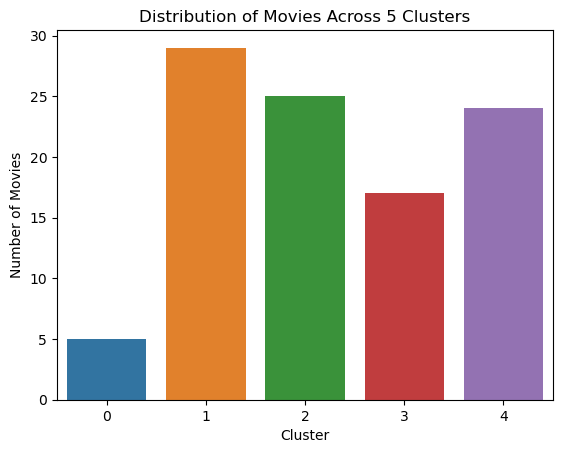

Most common genre in Cluster 0: Genre
crime drama    2
Name: count, dtype: int64
Most common genre in Cluster 1: Genre
drama    7
Name: count, dtype: int64
Most common genre in Cluster 2: Genre
science fiction    6
Name: count, dtype: int64
Most common genre in Cluster 3: Genre
drama    3
Name: count, dtype: int64
Most common genre in Cluster 4: Genre
drama    9
Name: count, dtype: int64


In [12]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming tfidf_matrix is already defined and ready to use

# Set up the dimensionality reduction and normalization pipeline
svd = TruncatedSVD(n_components=50)  # Adjust components based on previous analysis
normalizer = Normalizer()  # Normalize features to have unit norm
pipeline = make_pipeline(svd, normalizer)

# Transform the TF-IDF matrix using the pipeline
tfidf_reduced = pipeline.fit_transform(tfidf_matrix)

# Set up KMeans clustering
n_clusters = 5
km = KMeans(n_clusters=n_clusters, random_state=42)
clusters = km.fit_predict(tfidf_reduced)

# Assign clusters back to the original dataframe for further analysis
movies_df['cluster'] = clusters

# Print cluster counts to check the distribution
cluster_counts = pd.Series(clusters).value_counts()
print(f"Cluster distribution for {n_clusters} clusters: \n{cluster_counts}")

# Visualization of the cluster distribution
sns.countplot(x='cluster', data=movies_df)
plt.title(f'Distribution of Movies Across {n_clusters} Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Movies')
plt.show()

# Optionally, you can analyze each cluster for more insights, such as common genres or other metadata
def analyze_clusters(df):
    for i in range(n_clusters):
        cluster_genres = df[df['cluster'] == i]['Genre'].value_counts().head(1)
        print(f"Most common genre in Cluster {i}: {cluster_genres}")

analyze_clusters(movies_df)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lelin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


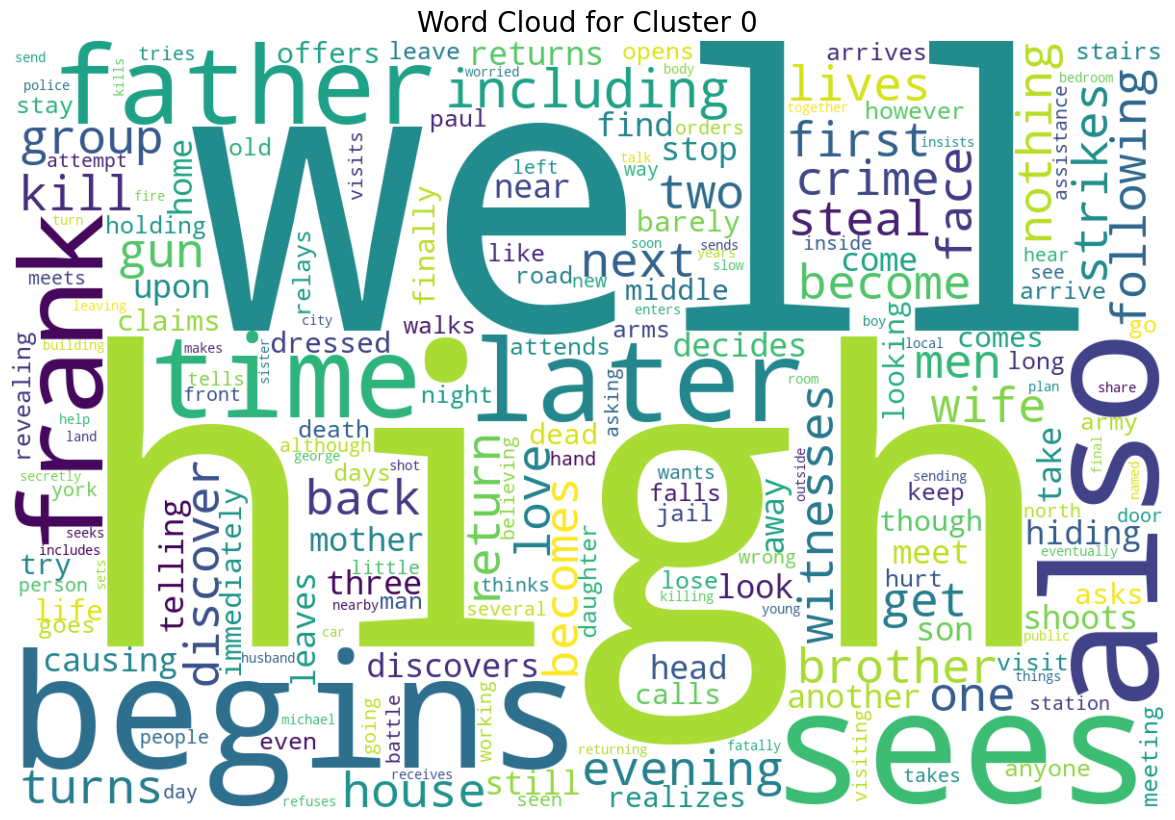

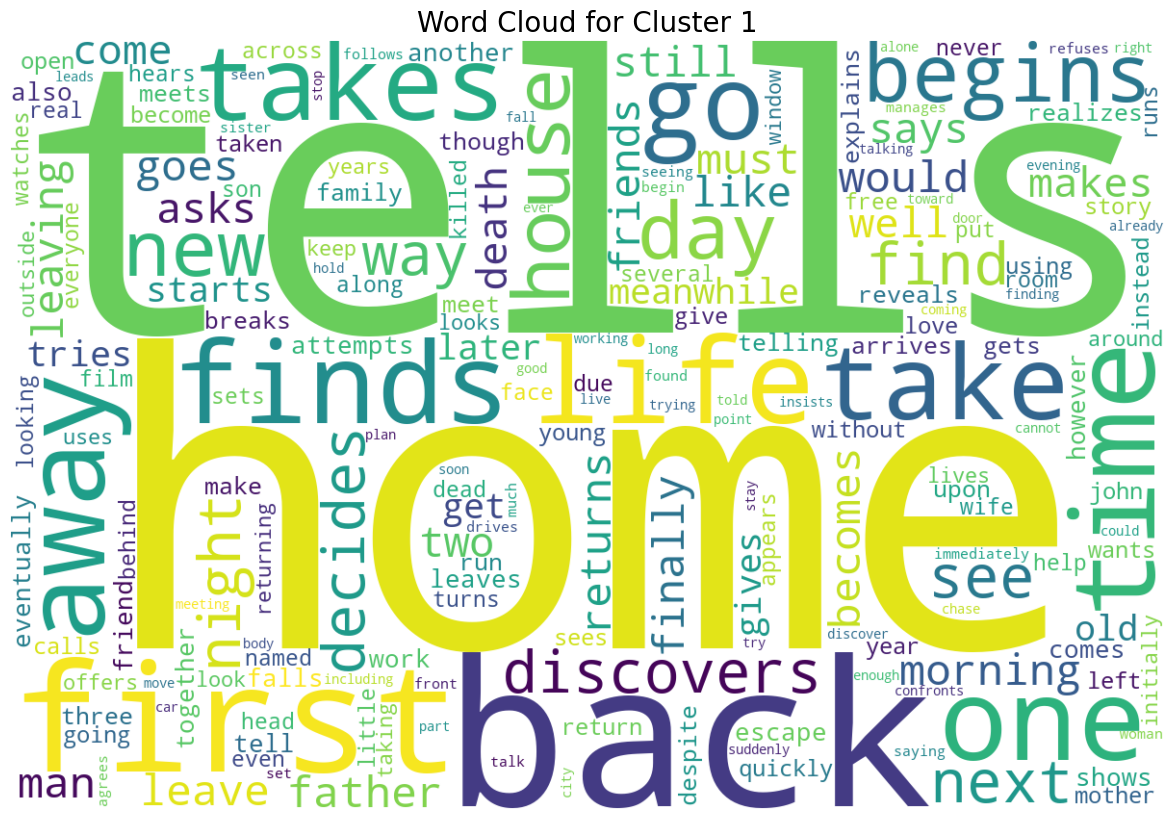

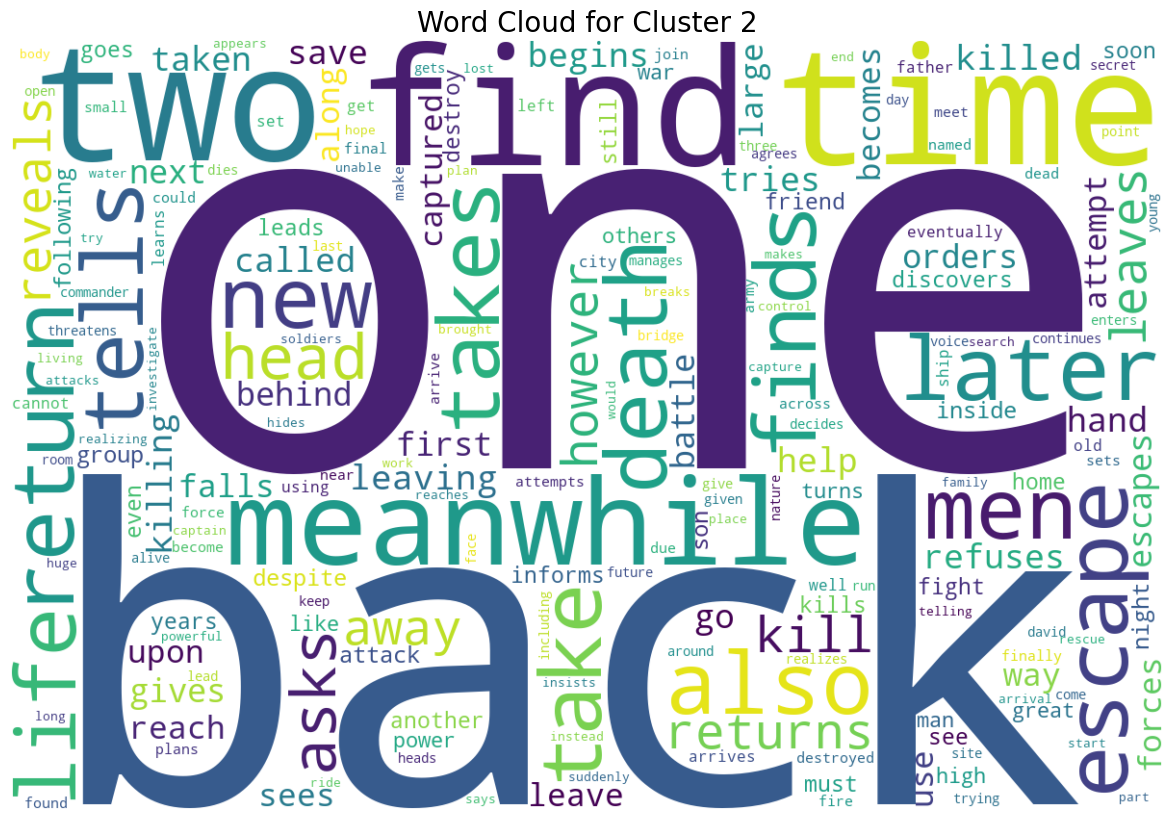

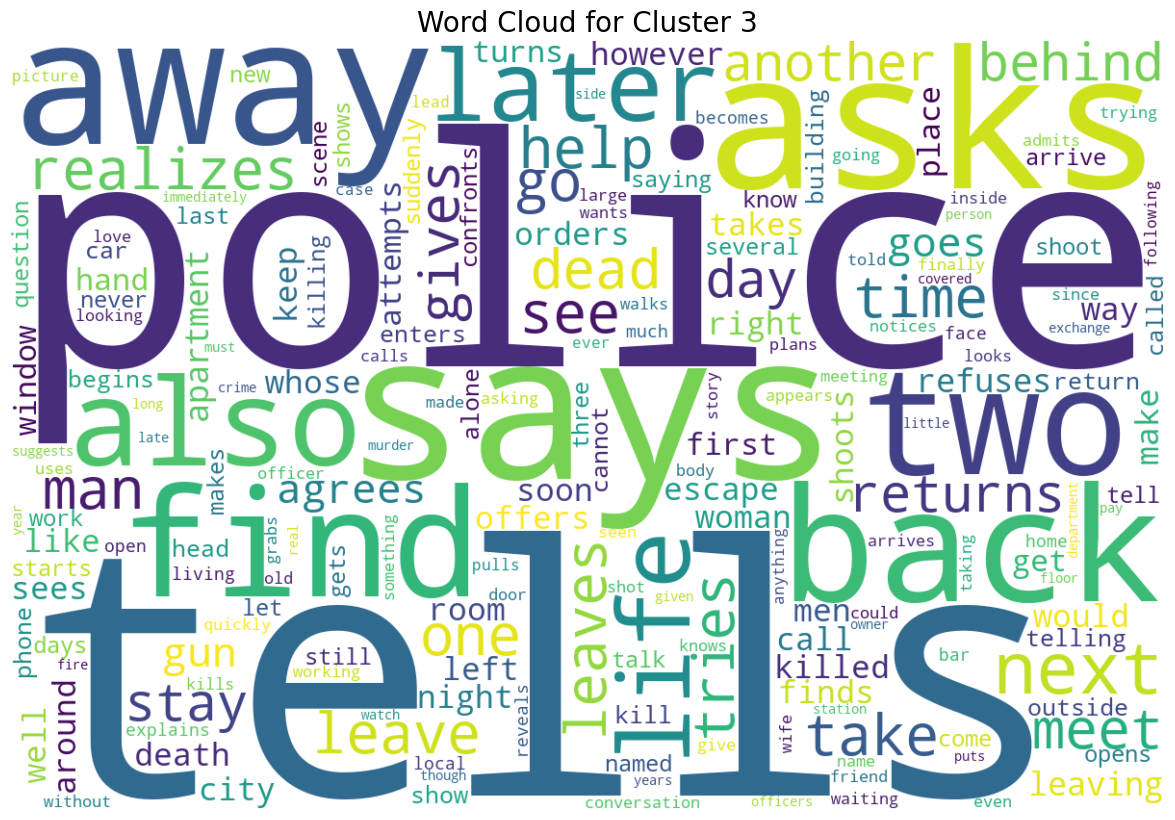

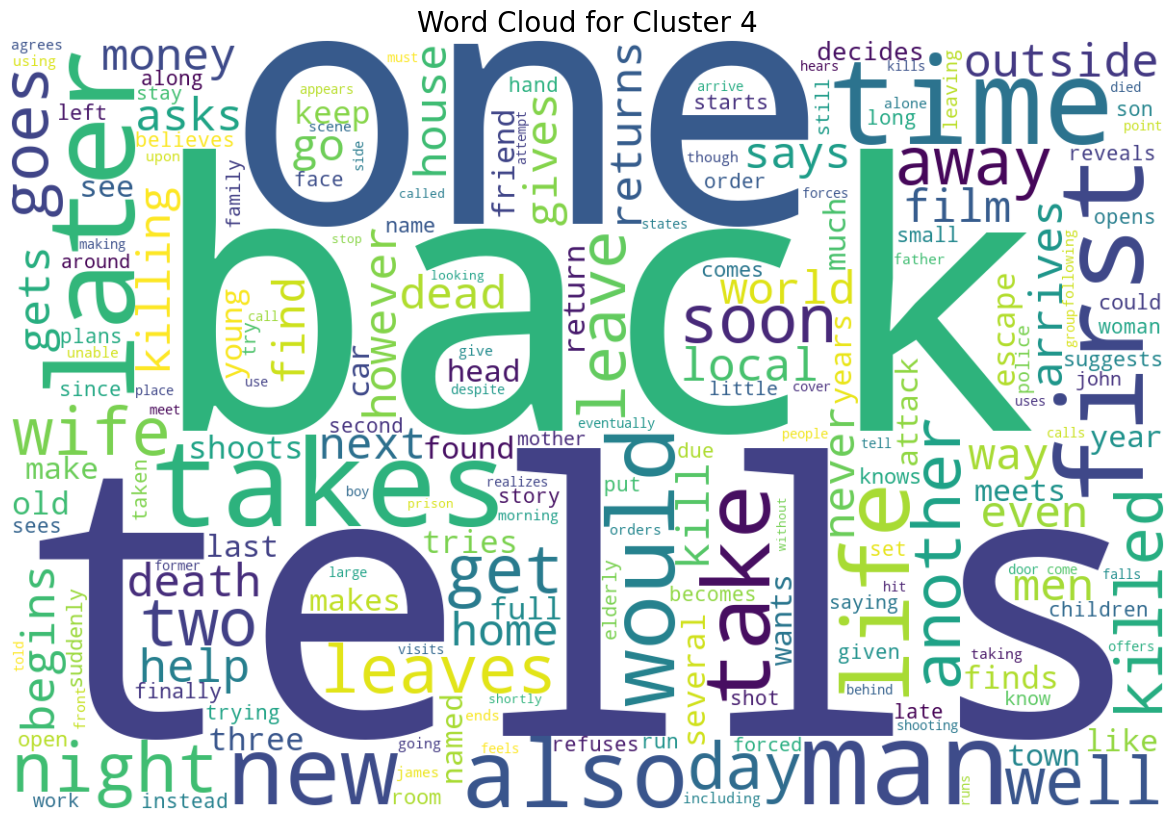

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords

# Ensure you have the stopwords dataset downloaded
nltk.download('stopwords')

def tokenize(text):
    # Basic tokenizer with word boundary; adapt as necessary
    return re.findall(r'\b\w+\b', text.lower())

def plot_cluster_wordclouds(df, km):
    # Load and extend the NLTK stopwords list
    stop_words = set(stopwords.words('english'))
    custom_stopwords = ['they', 'him', 'her', 'and','their','_x000d_','the']  # Add more custom stopwords as needed
    stop_words.update(custom_stopwords)

    for i in range(km.n_clusters):  # Assume km.n_clusters is defined from KMeans
        plt.figure(figsize=(15, 10))

        # Initialize a Counter object to store word frequencies
        word_counts = Counter()

        # Process each movie in the cluster
        for plot in df[df['cluster'] == i]['plot']:
            # Tokenize the plot text and update counts (only count each word once per movie)
            movie_words = set(tokenize(plot))
            # Remove stopwords from the set of words
            movie_words = movie_words - stop_words
            word_counts.update(movie_words)

        # Generate a word cloud from the aggregated word frequencies
        wordcloud = WordCloud(
            width=1200, 
            height=800, 
            background_color='white'
        ).generate_from_frequencies(word_counts)

        # Display the word cloud
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for Cluster {i}', fontsize=20)
        plt.show()

# Example usage; ensure km is your fitted KMeans model
plot_cluster_wordclouds(movies_df, km)


In [14]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_distance = 1 - cosine_similarity(tfidf_matrix)

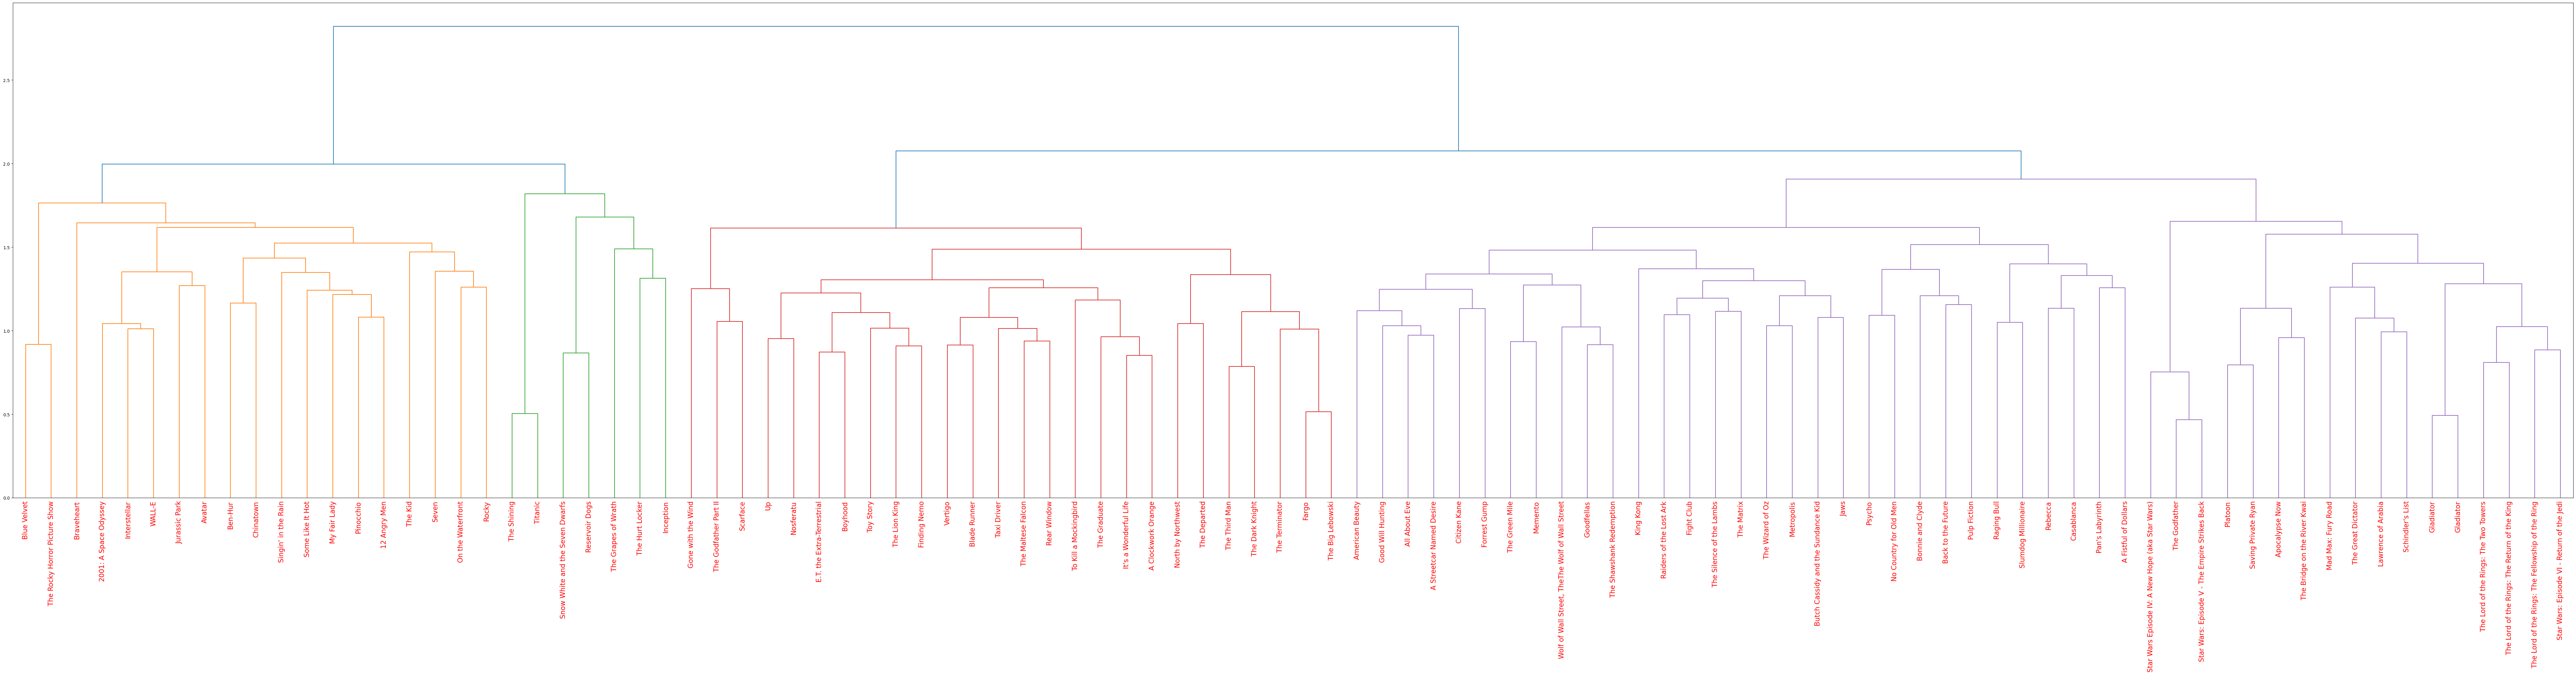

In [22]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# Assuming `similarity_distance` is already computed and available
mergings = linkage(similarity_distance, method='complete')
plt.figure(figsize=(108, 21))  # Set the size of the figure directly here

# Create the dendrogram
dendrogram_ = dendrogram(
    mergings,
    labels=[x for x in movies_df["Title"]],
    leaf_rotation=90,
    leaf_font_size=16,
)

# Access the current figure (moved this line up here for clarity)
fig = plt.gcf()
# Set the colors of labels to red
_ = [lbl.set_color('r') for lbl in plt.gca().get_xmajorticklabels()]

# Display the plot
plt.show()

# Define the path to save on Windows desktop
desktop_path = 'C:\\Users\\lelin\\Desktop\\dendrogram.jpg'  # Replace 'YourUsername' with your actual username

# Save the figure to a file on the desktop
fig.savefig(desktop_path, dpi=300) 

In [33]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def adjust_scores_by_genre(idx, genres, scores):
    selected_genres = set(genres[idx].split(', ')) if pd.notna(genres[idx]) else set()
    adjusted_scores = np.array(scores)  # Ensure numpy array for operations
    for i, genre in enumerate(genres):
        if pd.notna(genre):
            movie_genres = set(genre.split(', '))
            if selected_genres & movie_genres:  # Check if there is any intersection
                adjusted_scores[i] *= 1.30  # Increase the score by 30%
    return adjusted_scores

def get_similar_movies(movie_title, tfidf_matrix, movie_titles, feature_names, df, top_n=10):
    try:
        movie_idx = movie_titles.index(movie_title)
        genres = df['Genre'].tolist()  # Extract all genres from the DataFrame

        # Calculate cosine similarity
        similarity_scores = cosine_similarity(tfidf_matrix[movie_idx:movie_idx+1], tfidf_matrix).flatten()
        
        # Adjust scores based on genre
        similarity_scores = adjust_scores_by_genre(movie_idx, genres, similarity_scores)

        # Find indices of the most similar movies, excluding the selected movie itself
        similar_indices = np.argsort(similarity_scores)[::-1][1:top_n+1]

        # Generate output
        similar_movies = [(movie_titles[i], similarity_scores[i]) for i in similar_indices]

        # Optionally get common top words for additional context
        print(f"Top 10 common words between '{movie_title}' and '{movie_titles[similar_indices[0]]}':")
        common_words = get_common_top_words(tfidf_matrix, feature_names, movie_idx, similar_indices[0])
        for word, score in common_words:
            print(f"{word}: {score:.4f}")

        return similar_movies

    except ValueError:
        return "Movie not found."

In [34]:
movie_titles = movies_df['Title'].tolist()
feature_names = tfidf_vectorizer.get_feature_names_out()
selected_movie = 'Toy Story'

similar_movies = get_similar_movies(selected_movie, tfidf_matrix, movie_titles, feature_names, movies_df)
print(f"\nMovies similar to '{selected_movie}':")
for movie, score in similar_movies:
    print(f"{movie} (similarity score adjusted: {score:.4f})")

Top 10 common words between 'Toy Story' and 'Up':
hous: 0.6029
fall: 0.3759
get: 0.2609
move: 0.2576
land: 0.2175
fli: 0.2072
run: 0.1815
new: 0.1596
save: 0.1304

Movies similar to 'Toy Story':
Up (similarity score adjusted: 0.5170)
Fargo (similarity score adjusted: 0.4987)
The Lion King (similarity score adjusted: 0.4423)
Boyhood (similarity score adjusted: 0.4375)
The Big Lebowski (similarity score adjusted: 0.4327)
The Dark Knight (similarity score adjusted: 0.4211)
Psycho (similarity score adjusted: 0.4200)
It's a Wonderful Life (similarity score adjusted: 0.4128)
Finding Nemo (similarity score adjusted: 0.4121)
The Third Man (similarity score adjusted: 0.4120)
